In [94]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import numpy as np
import seaborn as sns

# handle filepaths
import os
import configparser

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
config_file =  os.path.join(root, 'config.cfg')

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config['geodata']['path']

## Load data

### London shapefiles

In [3]:
# get London borough shapefile
london = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, 'london-shapefiles\\London_Borough_Excluding_MHW.shp'))
london = london.to_crs('EPSG:4326')

# convert to correct CRS to have units in meters in the UK
_crs = "EPSG:32630"
london_reprojected = london.to_crs(_crs)

### Funding bids

In [60]:
funding = pd.read_csv("transport_bids_by_borough.csv", skiprows=2, usecols=[0,1,2,3], header=None, names=["GSS_CODE","borough", "cycling_bid", "cycling_funding"])

### TfL cycle routes

In [5]:
# load TFL cycle routes
tfl_cycle_routes = gpd.GeoDataFrame.from_file('TfL_CycleRoutes.json')

### Cycling rates

In [9]:
#read in each tab and merge into one table
rates_any = pd.read_excel("cw0302-proportion-of-adults-that-cycle-by-frequency-purpose-and-local-authority.xlsx", sheet_name="CW0302_Any_Purpose", skiprows=4)
rates_leisure = pd.read_excel("cw0302-proportion-of-adults-that-cycle-by-frequency-purpose-and-local-authority.xlsx", sheet_name="CW0302_Leisure", skiprows=4)
rates_travel = pd.read_excel("cw0302-proportion-of-adults-that-cycle-by-frequency-purpose-and-local-authority.xlsx", sheet_name="CW0302_Travel", skiprows=4)
rates = pd.concat([rates_any, rates_leisure, rates_travel])

In [44]:
# filter for london boroughs
rates = rates[rates["ONS Code"].isin(london["GSS_CODE"].unique().tolist() + ["E13000002", "E13000001", "E12000007"])]

# replace missing data
years = ['2016', '2017', '2018','2019', '2020', '2021', '2022']
for year in years:
    rates[year] = rates[year].replace("[u]", np.nan)

C:\Users\lisa.hornung\AppData\Local\Temp\ipykernel_5588\49594850.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rates[year] = rates[year].replace("[u]", np.nan)


### OSM data

Gets data from OSM using `osmnx` and save in csv files to load in for future runs

#### OSM road stats

road_stats = {"NAME": [],
              "OSM_street_length_total": []
              }

for i in range(len(london)):
    roads = ox.graph_from_polygon(london["geometry"][i],network_type='drive')
    basic_stats = ox.stats.basic_stats(roads, area=None)
    road_stats["NAME"].append(london["NAME"][i])
    road_stats["OSM_street_length_total"].append(basic_stats["street_length_total"])
    
road_stats_df = pd.DataFrame.from_dict(road_stats)

##### save output
road_stats_df.to_csv("OSM_road_stats_by_borough.csv", index=False)

In [26]:
# load preprocessed csv file
road_stats_df = pd.read_csv("OSM_road_stats_by_borough.csv")

#### OSM cycle routes

Useful code in [this tutorial](https://williamthyer.github.io/posts/2021/4/bike_networks/) and 
the [original Github Thread](https://github.com/gboeing/osmnx/issues/151)

Example notebooks in docs: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/08-custom-filters-infrastructure.ipynb

In [6]:
# Configuring osmnx
ox.settings.useful_tags_way += ["cycleway"]

def get_cycleways_polygon(polygon):    
    # Querying for roads and bike trails
    cycleways = ox.graph_from_polygon(polygon, network_type='bike', simplify=True)
    
    # Finding all non-cycleways in the network
    non_cycleways = [(u, v, k) for  u, v, k, d  in  cycleways.edges(keys=True, data=True) if  not ('cycleway'  in  d  or  d['highway']=='cycleway')]
   
    # Remove non-cycleways and isolated nodes
    cycleways.remove_edges_from(non_cycleways)
    cycleways = ox.utils_graph.remove_isolated_nodes(cycleways)
    
    return cycleways

cycleways_df = []
cycle_stats = {"NAME": [],
              "OSM_cycleways_length_total": [],
              }

for i in range(len(london)):
    ###### get cycleways for each borough
    polygon = london["geometry"][i]
    cycleways = get_cycleways_polygon(polygon)

    ###### get basic stats
    basic_stats = ox.stats.basic_stats(cycleways, area=None)
    cycle_stats["NAME"].append(london["NAME"][i])
    cycle_stats["OSM_cycleways_length_total"].append(basic_stats["street_length_total"])

    ###### turn cycleways into gdf
    cycleways_df_single = ox.utils_graph.graph_to_gdfs(cycleways, nodes=False, edges=True)
    cols = ['highway',  'cycleway', 'length', 'geometry']
    cycleways_df_single = cycleways_df_single[cols].reset_index(drop=True)
    cycleways_df_single["NAME"] = london["NAME"][i]
    cycleways_df.append(cycleways_df_single)

osm_cycleways_df = pd.concat(cycleways_df, ignore_index=True)
osm_cycleways_stats_df = pd.DataFrame.from_dict(cycle_stats)

##### save outputs
osm_cycleways_df = osm_cycleways_df.rename_geometry('WKT')
osm_cycleways_df.to_csv("OSM_cycleways_by_borough.csv", index=False)
osm_cycleways_stats_df.to_csv("OSM_cycleways_stats_by_borough.csv", index=False)

In [133]:
# load preprocessed csv file
osm_cycleways_stats_df = pd.read_csv("OSM_cycleways_stats_by_borough.csv")
osm_cycleways_gdf = gpd.read_file("OSM_cycleways_by_borough.csv")
osm_cycleways_gdf = osm_cycleways_gdf.set_crs('EPSG:4326')

### Combined cycle infra

To DO: remove overlaps between line strings

In [227]:
cycleways_gdf = gpd.GeoDataFrame(pd.concat([osm_cycleways_gdf["geometry"],tfl_cycle_routes["geometry"]]))
cycleways_gdf.head()

,geometry
0,"LINESTRING (-0.25684 51.43567, -0.25688 51.435..."
1,"LINESTRING (-0.25568 51.43594, -0.25561 51.43590)"
2,"LINESTRING (-0.25568 51.43594, -0.25572 51.435..."
3,"LINESTRING (-0.26515 51.43135, -0.26544 51.431..."
4,"LINESTRING (-0.26834 51.42944, -0.26846 51.42940)"


## Process data

In [61]:
gdf = london[['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'geometry']]

In [90]:
# map inner and outer boroughs
inner = [ "E09000007", "E09000001", "E09000012", "E09000013", "E09000014", "E09000019", "E09000020", 
        "E09000022" , "E09000023", "E09000025", "E09000028", "E09000030", "E09000032", "E09000033"]
outer = ["E09000002", "E09000003", "E09000004", "E09000005" , "E09000006", "E09000008", "E09000009", "E09000010",
        "E09000011", "E09000015",  "E09000016", "E09000017", "E09000018" , "E09000021", "E09000024", "E09000026",
        "E09000027", "E09000029", "E09000031"]

inner_outer_dict = dict(zip(outer + inner, ["Outer London"] * len(outer) + ["Inner London"] * len(inner)))
gdf["Borough_class"] = gdf["GSS_CODE"].map(inner_outer_dict)

### Merge data

In [62]:
# funding
gdf = pd.merge(gdf, funding[["GSS_CODE","cycling_bid", "cycling_funding"]], left_on="GSS_CODE", right_on="GSS_CODE", how="left")

In [63]:
# OMS stats
gdf = pd.merge(gdf, road_stats_df, left_on="NAME", right_on="NAME", how="left")
gdf = pd.merge(gdf, osm_cycleways_stats_df, left_on="NAME", right_on="NAME", how="left")

In [64]:
# TfL route lengths
tfl_cycle_routes_total_length = []
tfl_cycle_routes_open_length = []
tfl_cycle_routes_planned_length = []

for i in range(len(london)):
    routes_clipped = gpd.clip(tfl_cycle_routes, london["geometry"][i], keep_geom_type=True)
    tfl_cycle_routes_total_length.append(routes_clipped["Shape_Leng"].sum())

    open_routes_clipped = gpd.clip(tfl_cycle_routes[tfl_cycle_routes["Status"]=="Open"], london["geometry"][i], keep_geom_type=True)
    tfl_cycle_routes_open_length.append(open_routes_clipped["Shape_Leng"].sum())

    planned_routes_clipped = gpd.clip(tfl_cycle_routes[tfl_cycle_routes["Status"]!="Open"], london["geometry"][i], keep_geom_type=True)
    tfl_cycle_routes_planned_length.append(planned_routes_clipped["Shape_Leng"].sum())

# add to gdf
gdf.loc[:,"tfl_cycle_routes_total_length"] = tfl_cycle_routes_total_length
gdf.loc[:,"tfl_cycle_routes_open_length"] = tfl_cycle_routes_open_length
gdf.loc[:,"tfl_cycle_routes_planned_length"] = tfl_cycle_routes_planned_length

In [65]:
# cycling rates
_filter = (rates["Frequency"]=="At least once per week") & (rates["Purpose"]=="Any")
weekly_rate = rates[_filter][["ONS Code", "2022"]].rename(columns={"ONS Code": "GSS_CODE","2022":"rate_weekly_any_2022"})

_filter = (rates["Frequency"]=="At least once per month") & (rates["Purpose"]=="Any")
monthly_rate = rates[_filter][["ONS Code", "2022"]].rename(columns={"ONS Code": "GSS_CODE","2022":"rate_monthly_any_2022"})

gdf = pd.merge(gdf, weekly_rate, left_on="GSS_CODE", right_on="GSS_CODE", how="left")
gdf = pd.merge(gdf, monthly_rate, left_on="GSS_CODE", right_on="GSS_CODE", how="left")

### Calculate ratios

In [77]:
# calculate cycle routes ratio of total street network
gdf["TfL_cycle_ratio"] = gdf["tfl_cycle_routes_open_length"] / gdf["OSM_street_length_total"]
gdf["TfL_cycle_ratio_total"] = gdf["tfl_cycle_routes_total_length"] / gdf["OSM_street_length_total"]

# calculate cycle routes ratio of total street network
gdf["OSM_cycle_ratio"] = gdf["OSM_cycleways_length_total"] / gdf["OSM_street_length_total"]

## Explore

<Axes: xlabel='TfL_cycle_ratio', ylabel='rate_monthly_any_2022'>

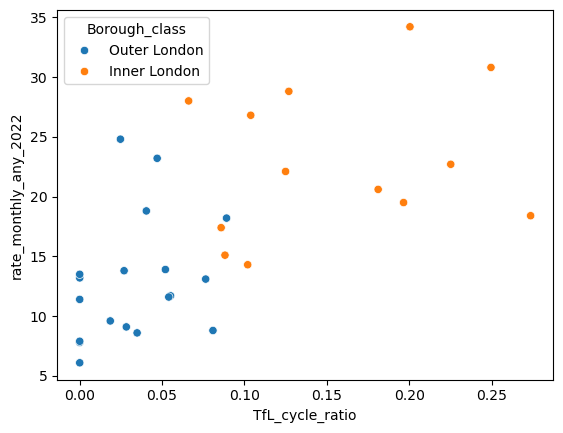

In [222]:
sns.scatterplot(data=gdf, x="TfL_cycle_ratio", y="rate_monthly_any_2022", hue="Borough_class")

<Axes: xlabel='OSM_cycle_ratio', ylabel='rate_monthly_any_2022'>

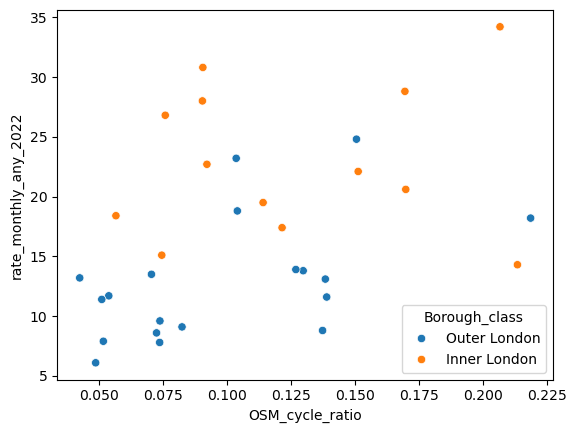

In [221]:
sns.scatterplot(data=gdf, x="OSM_cycle_ratio", y="rate_monthly_any_2022", hue="Borough_class")

<Axes: xlabel='tfl_cycle_routes_total_length', ylabel='cycling_funding'>

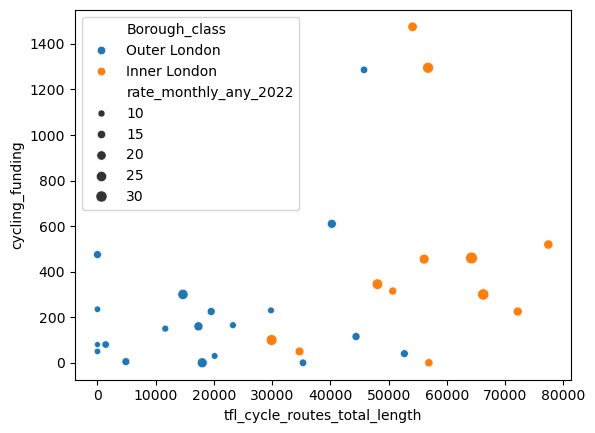

In [121]:
sns.scatterplot(data=gdf, y="cycling_funding", x="tfl_cycle_routes_total_length", size="rate_monthly_any_2022", hue="Borough_class") 

<Axes: xlabel='cycling_funding', ylabel='rate_monthly_any_2022'>

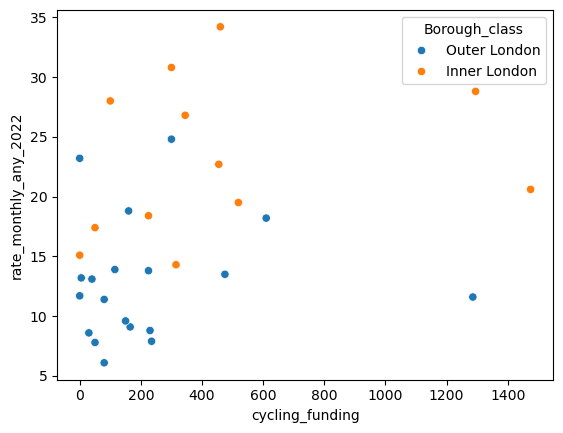

In [219]:
sns.scatterplot(data=gdf, x="cycling_funding", y="rate_monthly_any_2022", hue="Borough_class") 

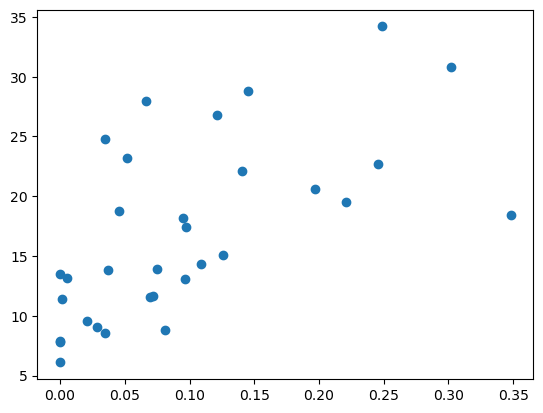

In [78]:
plt.scatter(gdf["TfL_cycle_ratio_total"], gdf["rate_monthly_any_2022"])

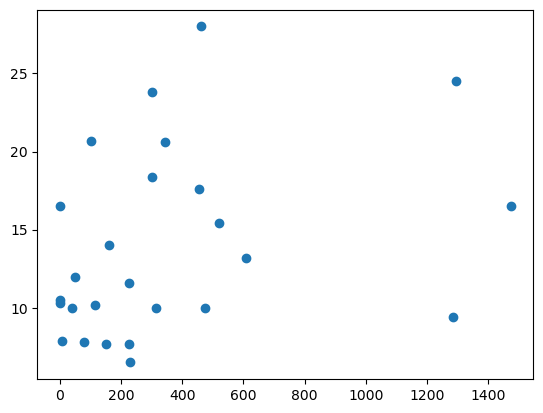

In [216]:
plt.scatter(gdf["cycling_funding"], gdf["rate_weekly_any_2022"])

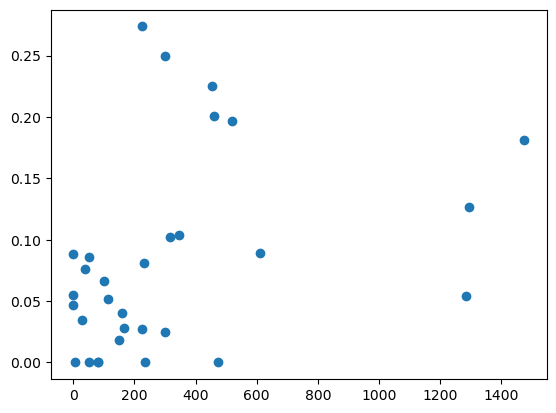

In [72]:
_filter = gdf["NAME"]!= "City of London"
plt.scatter(gdf[_filter]["cycling_funding"], gdf[_filter]["TfL_cycle_ratio"])

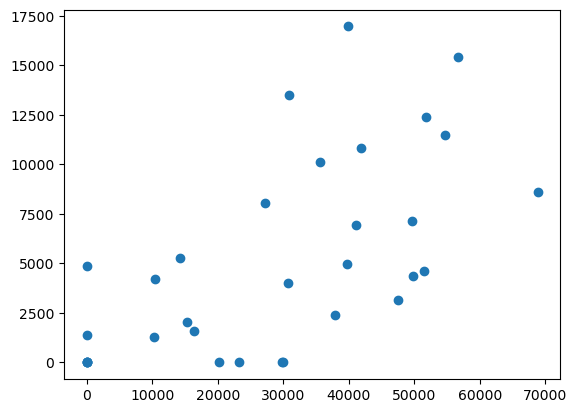

In [75]:
_filter = gdf["NAME"]!= "City of London"
plt.scatter(gdf[_filter]["tfl_cycle_routes_open_length"], gdf[_filter]["tfl_cycle_routes_planned_length"])

In [73]:
gdf.columns

Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'geometry',
       'cycling_bid', 'cycling_funding', 'OSM_street_length_total',
       'OSM_cycleways_length_total', 'tfl_cycle_routes_total_length',
       'tfl_cycle_routes_open_length', 'tfl_cycle_routes_planned_length',
       'rate_weekly_any_2022', 'rate_monthly_any_2022', 'TfL_cycle_ratio'],
      dtype='object')

<Axes: >

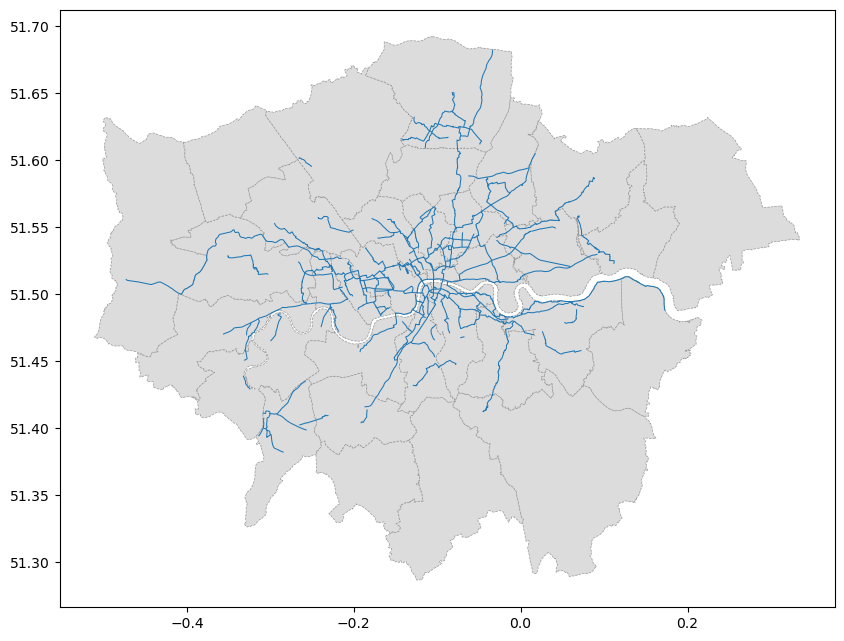

In [215]:
fig, ax = plt.subplots(figsize=(10,8))

london.plot(ax=ax, color='#DCDCDC', linewidth=0.5, edgecolor="#999999", linestyle="dashed")
#osm_cycleways_gdf.plot(ax=ax, color="red", linewidth=0.5)
tfl_cycle_routes.plot(ax=ax, linewidth=0.75)